## This notebook assumes that you have extracted the embeddings (using the procedure mentioned in the 0_ESM_Embeddings_Extractor.ipynb notebook) and have stored them in a zipped forma

## Since we have used google colab; we copy the embeddings from google drive before training the model; similar procedure can be used to run it locally;

## A example is shown below for CDR3alpha, CDR3beta and peptide:

In [2]:
#####################################################1_origMCPAS_NoMHC/train_AB
!cp -r /content/drive/MyDrive/TCR-pMHC-results/vdjdb/1_origVDJDB_NoMHC/train_AB/*.csv '/content/'
!cp -r /content/drive/MyDrive/TCR-pMHC-results/vdjdb/1_origVDJDB_NoMHC/train_AB/*.zip '/content'

## A example is shown below for CDR3alpha, CDR3beta, peptide and MHC:

## Unzip the embeddings to folder for developing the train and test set

In [3]:
########################################################################## AB and A
#### unzip train
!unzip -q <path_to_train_cdr3a.zip>     -d  train_cdr3a
!unzip -q <path_to_train_cdr3b.zip>     -d  train_cdr3b
!unzip -q <path_to_train_peptide.zip>   -d  train_peptide

#### unzip test
!unzip -q <path_to_test_cdr3a.zip>     -d  test_cdr3a
!unzip -q <path_to_test_cdr3b.zip>     -d  test_cdr3b
!unzip -q <path_to_test_peptide.zip>   -d  test_peptide


In [4]:
import sys
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from natsort import natsorted
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer,Input, Dense, Dropout, Activation, Concatenate, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow.keras.metrics
####import tensorflow_addons as tfa not required
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
tf.random.set_seed(1)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical, plot_model
import sklearn
import os
from natsort import natsorted
from sklearn.metrics import *
import torch
from tqdm import tqdm
from collections import Counter

## For MCPAS subset-1 which doesn't have MHC information
### Model CDR3a + CDR3b + peptide
### Model CDR3a + peptide
### Model CDR3b + peptide

In [7]:
# ### train files
# ################################################################################ AB and A and B
path_train_cdr3a = '/content/train_cdr3a/content/train_cdr3a/'
path_train_cdr3b = '/content/train_cdr3b/content/train_cdr3b/'
path_train_pepti = '/content/train_peptide/content/train_pep/'

### test files
path_test_cdr3a = '/content/test_cdr3a/content/test_cdr3a/'
path_test_cdr3b = '/content/test_cdr3b/content/test_cdr3b/'
path_test_pepti = '/content/test_peptide/content/test_pep/'



trainmat_cdr3a = os.listdir(path_train_cdr3a) 
trainmat_cdr3b = os.listdir(path_train_cdr3b) 
trainmat_pepti = os.listdir(path_train_pepti)


testmat_cdr3a = os.listdir(path_test_cdr3a) 
testmat_cdr3b = os.listdir(path_test_cdr3b) 
testmat_pepti = os.listdir(path_test_pepti)


## natsort is used to order the pairs as they appear in the .csv; this would be helpful later to map the pairs with their respective labels

In [8]:
# ###train ################################################ AB A B
###train
train_nmat_cdr3a = natsorted(trainmat_cdr3a)
train_nmat_cdr3b = natsorted(trainmat_cdr3b)
train_nmat_pepti = natsorted(trainmat_pepti)

###test
test_nmat_cdr3a = natsorted(testmat_cdr3a)
test_nmat_cdr3b = natsorted(testmat_cdr3b)
test_nmat_pepti = natsorted(testmat_pepti)

## the following step extracts the embeddings and stores in a numpy matrix

In [13]:
train_matmat_cdr3a = np.zeros((train_samples,1280))
train_matmat_cdr3b = np.zeros((train_samples,1280))
train_matmat_pepti = np.zeros((train_samples,1280))


test_matmat_cdr3a = np.zeros((test_samples,1280))
test_matmat_cdr3b = np.zeros((test_samples,1280))
test_matmat_pepti = np.zeros((test_samples,1280))

### load train samples 

for i in tqdm(range(train_samples)):

    train_matmat_cdr3a[i] = torch.load(path_train_cdr3a+train_nmat_cdr3a[i])['mean_representations'][33]

    train_matmat_cdr3b[i] = torch.load(path_train_cdr3b+train_nmat_cdr3b[i])['mean_representations'][33]

    train_matmat_pepti[i] = torch.load(path_train_pepti+train_nmat_pepti[i])['mean_representations'][33]


for j in tqdm(range(test_samples)):

    test_matmat_cdr3a[j]  = torch.load(path_test_cdr3a+test_nmat_cdr3a[j])['mean_representations'][33]

    test_matmat_cdr3b[j]  = torch.load(path_test_cdr3b+test_nmat_cdr3b[j])['mean_representations'][33]

    test_matmat_pepti[j]  = torch.load(path_test_pepti+test_nmat_pepti[j])['mean_representations'][33]

100%|██████████| 5611/5611 [00:04<00:00, 1125.60it/s]


## load *.csv files for labels

In [15]:
df_train = pd.read_csv(<path_to_train_csv>)
df_test  = pd.read_csv(<path_to_test_csv>)

############ load labels

y_train = df_train['sign'].values.reshape(-1,1)
y_test  = df_test['sign'].values.reshape(-1,1)

In [17]:
### model
def clear_sess():
  try:
    del model 
    del history 
  except:
    pass
  from tensorflow.keras import backend as K
  K.clear_session()
  import gc
  gc.collect()



  return None

def keras_mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

### model for CDR3A, CDR3B and peptide  AB

In [ ]:
clear_sess()


acti  = 'gelu'

#input_1
input_1 = Input(shape = (1280,), name='i_1')
dense1_1 = Dense(128, activation = acti)(input_1)
bn1_1 = BatchNormalization()(dense1_1)
drop_1 = Dropout(0.5)(bn1_1)

#input_2
input_2 = Input(shape = (1280,), name='i_2')
dense2_1 = Dense(128, activation = acti)(input_2)
bn2_1 = BatchNormalization()(dense2_1)
drop_2 = Dropout(0.5)(bn2_1)

#input_3
input_3 = Input(shape = (1280,), name='i_3')
dense3_1 = Dense(128, activation = acti)(input_3)
bn3_1 = BatchNormalization()(dense3_1)
drop_3 = Dropout(0.5)(bn3_1)

# concatenate
concat   = Concatenate()([drop_1,drop_2,drop_3])
fc_1   = Dense(512, activation = acti)(concat)
drop_4 = Dropout(0.5)(fc_1)
fc_2   = Dense(256, activation = acti)(drop_4)
#classification output- TCR-Peptide Binding yes/no
output  = Dense(1, activation = 'sigmoid')(fc_2)
 
# create model with two inputs
model = Model(inputs=[input_1,input_2, input_3], outputs=output)

## CDR3A peptide and CDR3B peptide

In [ ]:
clear_sess()

acti  = 'swish'

#input_1
input_1 = Input(shape = (1280,), name='i_1')
dense1_1 = Dense(128, activation = acti)(input_1)
bn1_1 = BatchNormalization()(dense1_1)
drop_1 = Dropout(0.5)(bn1_1)

#input_2
input_2 = Input(shape = (1280,), name='i_2')
dense2_1 = Dense(128, activation = acti)(input_2)
bn2_1 = BatchNormalization()(dense2_1)
drop_2 = Dropout(0.5)(bn2_1)


# concatenate
concat   = Concatenate()([drop_1,drop_2])
fc_1   = Dense(512, activation = acti)(concat)
drop_4 = Dropout(0.5)(fc_1)
fc_2   = Dense(256, activation = acti)(drop_4)
#classification output- TCR-Peptide Binding yes/no
output  = Dense(1, activation = 'sigmoid')(fc_2)
 
# create model with two inputs
model = Model(inputs=[input_1,input_2], outputs=output)

In [ ]:
metrics_c = [tensorflow.keras.metrics.AUC(name="auc_roc",curve="ROC"),tensorflow.keras.metrics.AUC(name="auc_pr",curve="PR"),keras_mcc]
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.009),   metrics=metrics_c)
reduce_lr = ReduceLROnPlateau(monitor='val_keras_mcc', factor=0.95,patience=50, min_lr=0.004, verbose=0)

In [ ]:
checkpoint_filepath_1 = 'weights-improvement-val-auc-pr.hdf5'
model_checkpoint_callback_1 = ModelCheckpoint(filepath=checkpoint_filepath_1,save_weights_only=False,monitor='val_auc_pr',mode='max',save_best_only=True)

checkpoint_filepath_2 = 'weights-improvement-val-keras-mcc.hdf5'
model_checkpoint_callback_2 = ModelCheckpoint(filepath=checkpoint_filepath_2,save_weights_only=False,monitor='val_keras_mcc',mode='max',save_best_only=True)

In [ ]:
### recheck data dims
print('Training', train_matmat_cdr3a.shape, train_matmat_cdr3b.shape, train_matmat_pepti.shape, y_train.shape)
print('Testing ', test_matmat_cdr3a.shape,  test_matmat_cdr3b.shape,  test_matmat_pepti.shape,  y_test.shape)

Training (23363, 1280) (23363, 1280) (23363, 1280) (23363, 1)
Testing  (5611, 1280) (5611, 1280) (5611, 1280) (5611, 1)


### fit the keras model for CDR3A, CDR3B and peptide

In [ ]:
history=model.fit([train_matmat_cdr3a, train_matmat_cdr3b,train_matmat_pepti],y_train,
                  batch_size=1024, epochs=500,
                  validation_split=0.1,
                  callbacks=[model_checkpoint_callback_1, model_checkpoint_callback_2,reduce_lr])

### fit the keras model for CDR3B and peptide

In [ ]:
history=model.fit([train_matmat_cdr3b,train_matmat_pepti],y_train,
                  batch_size=1024, epochs=1000,
                  validation_split=0.1,
                  callbacks=[model_checkpoint_callback_1, model_checkpoint_callback_2,reduce_lr])

### fit the keras model for CDR3A and peptide

In [ ]:
history=model.fit([train_matmat_cdr3a, train_matmat_pepti],y_train,
                  batch_size=1024, epochs=500,
                  validation_split=0.1,
                  callbacks=[model_checkpoint_callback_1, model_checkpoint_callback_2,reduce_lr])

## once the best model is trained, we can test it over the evaluation datase

In [18]:


model_loaded = '/content/weights-improvement-val-keras-mcc.hdf5'
model = tensorflow.keras.models.load_model(model_loaded,compile=False, custom_objects={'metrics_c': keras_mcc})

# model_loaded = '/content/weights-improvement-val-auc-pr.hdf5'
# model = tensorflow.keras.models.load_model(model_loaded,compile=False, custom_objects={'metrics_c': keras_mcc})

y_pred = model.predict([test_matmat_cdr3a, test_matmat_cdr3b, test_matmat_pepti])
# y_pred = model.predict([test_matmat_cdr3b, test_matmat_pepti])
#y_pred = model.predict([ test_matmat_cdr3a, test_matmat_pepti])


y_act = y_test.flatten()
y_pred= y_pred.flatten()
y_pred_c=np.where(y_pred>0.5,1,0)


print(roc_auc_score(y_act, y_pred),average_precision_score(y_act, y_pred), matthews_corrcoef(y_act,y_pred_c),f1_score(y_act,y_pred_c))

176/176 [==============================] - 1s 3ms/step
0.6731087070007619


## Embedding analysis

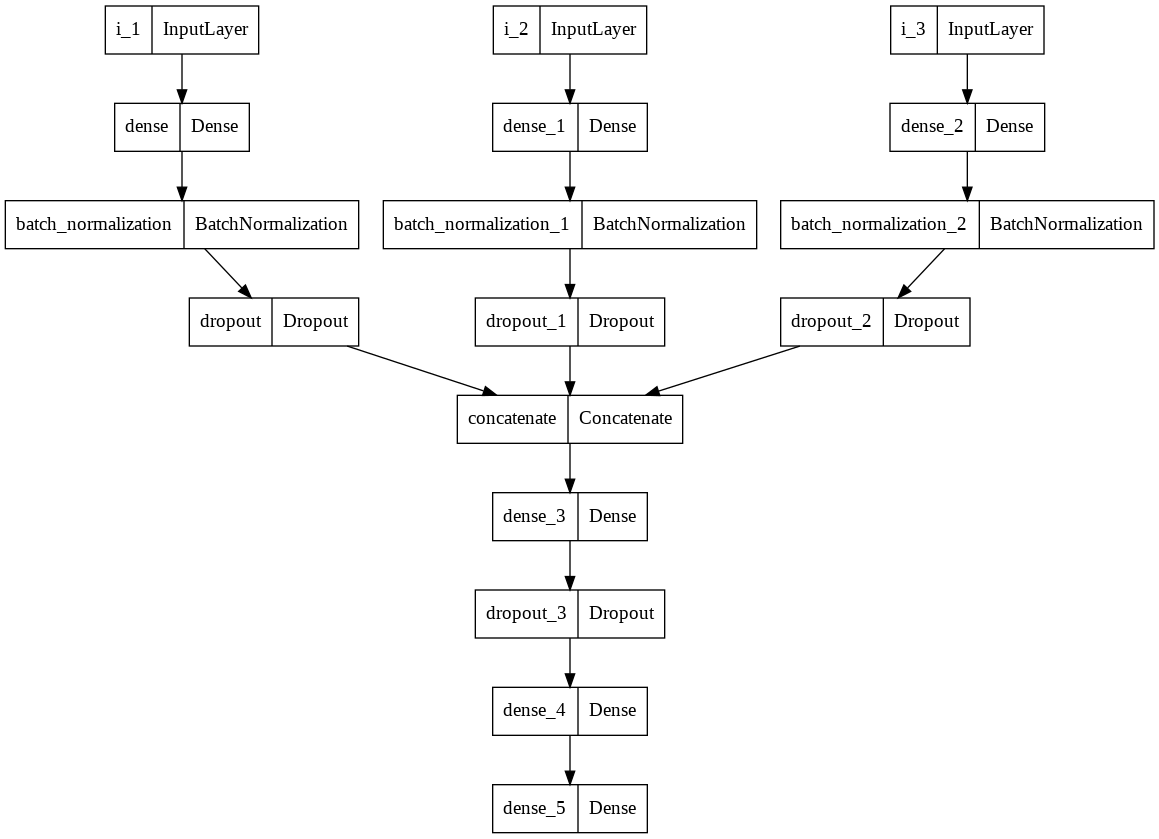

In [ ]:
plot_model(model)

## Extract Embeddings

In [19]:
[layer.output for layer in model.layers]

[<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'i_1')>,
 <KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'i_2')>,
 <KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'i_3')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_2')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dropout_2')>,
 <KerasTensor: shape=(None, 384

In [51]:
# ### intermediate layer model on test for alpha - beta - pep model
# layer_name_1 = 'i_1' ### alpha input
# intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
# intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a, test_matmat_cdr3b,test_matmat_pepti])
# intermediate_output_1 = intermediate_output_1.numpy()

# layer_name_1 = 'i_2' #beta input
# intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
# intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a, test_matmat_cdr3b,test_matmat_pepti])
# intermediate_output_1 = intermediate_output_1.numpy()

# layer_name_1 = 'concatenate' ## intermediate layer
# intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
# intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a, test_matmat_cdr3b,test_matmat_pepti])
# intermediate_output_1 = intermediate_output_1.numpy()

# layer_name_1 = 'dense_3' ## intermediate #2 layer
# intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
# intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a, test_matmat_cdr3b,test_matmat_pepti])
# intermediate_output_1 = intermediate_output_1.numpy()

layer_name_1 = 'dense_3' ## intermediate #3 layer
intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a, test_matmat_cdr3b,test_matmat_pepti])
intermediate_output_1 = intermediate_output_1.numpy()

In [ ]:
### intermediate layer model on test for alpha pep and beta - pep model
# layer_name_1 = 'i_1' ### alpha input
# intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
# # intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a,test_matmat_pepti])
# intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3b,test_matmat_pepti])
# intermediate_output_1 = intermediate_output_1.numpy()

# layer_name_1 = 'dense' ### 
# intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
# # intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a,test_matmat_pepti])
# intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3b,test_matmat_pepti])
# intermediate_output_1 = intermediate_output_1.numpy()

# layer_name_1 = 'concatenate' ### 
# intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
# # intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a,test_matmat_pepti])
# intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3b,test_matmat_pepti])
# intermediate_output_1 = intermediate_output_1.numpy()

# layer_name_1 = 'dense_2' ### 
# intermediate_layer_model_1 = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name_1).output)
# intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3a,test_matmat_pepti])
# #intermediate_output_1 = intermediate_layer_model_1([test_matmat_cdr3b,test_matmat_pepti])
# intermediate_output_1 = intermediate_output_1.numpy()

In [53]:
intermediate_output_1.shape
#, intermediate_output_2.shape

(5611, 512)

In [52]:
pep_list=df_test['peptide'].values.tolist()

In [242]:
Counter(pep_list).most_common(30)

[('LPRRSGAAGA', 718),
 ('GILGFVFTL', 628),
 ('GLCTLVAML', 348),
 ('SSYRRPVGI', 342),
 ('NLVPMVATV', 313),
 ('SSLENFRAYV', 246),
 ('ASNENMETM', 183),
 ('CRVLCCYVL', 167),
 ('LLWNGPMAV', 152),
 ('HGIRNASFI', 132),
 ('RFYKTLRAEQASQ', 120),
 ('WEDLFCDESLSSPEPPSSSE', 111),
 ('ELAGIGILTV', 106),
 ('FRCPRRFCF', 103),
 ('VTEHDTLLY', 102),
 ('SSPPMFRV', 84),
 ('EAAGIGILTV', 83),
 ('LSLRNPILV', 83),
 ('TPRVTGGGAM', 83),
 ('SFHSLHLLF', 78),
 ('VEALYLVCG', 76),
 ('RPHERNGFTVL', 71),
 ('RAKFKQLL', 57),
 ('TVYGFCLL', 55),
 ('KAFSPEVIPMF', 46),
 ('FPRPWLHGL', 38),
 ('NLNCCSVPV', 33),
 ('PQPELPYPQPE', 30),
 ('KRWIILGLNK', 30),
 ('YVLDHLIVV', 27)]

In [253]:
# c_pep ='GILGFVFTL' 
# c_pep = 'SSYRRPVGI'
# c_pep = 'NLVPMVATV' 
# c_pep = 'SSLENFRAYV' 
# c_pep = 'ASNENMETM' 
# c_pep = 'LLWNGPMAV' 
# c_pep = 'HGIRNASFI' 
# c_pep = 'SSPPMFRV'

In [254]:
intermediate_output_fil =  intermediate_output_1[df_test['peptide']==c_pep]

df_test_pepfil = df_test[df_test['peptide']==c_pep]

## TSNE to map to 2D

In [256]:
reducer = TSNE(n_components=2, verbose=0, perplexity=10, n_iter=5000, metric='euclidean')
results_tsne = reducer.fit_transform(intermediate_output_fil)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [257]:
plt.rcParams.update(plt.rcParamsDefault)
sns.set(font_scale=2)
sns.set_style('ticks')
df_subset = pd.DataFrame()

df_subset['tsne-1'] = results_tsne[:,0]
df_subset['tsne-2'] = results_tsne[:,1]
df_subset['Binding']           = df_test_pepfil['sign'].values.flatten()

rep_dict = {0:'Negative', 1:'Positive'}
df_subset.replace({"Binding": rep_dict },inplace=True)



In [261]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="Binding",
    palette=sns.color_palette("tab10", 2)[::-1],
    # palette=sns.color_palette("tab10", 2),
    data = df_subset,
    legend="full",
    alpha=0.9,
    s=50
)

# handles_ax, labels_ax = ax.get_legend_handles_labels()
# plt.legend(reversed(handles_ax), reversed(labels_ax), title='TCR Binding', loc='lower right',)
plt.legend(title='TCR Binding')
# plt.xlim(-500,500)
# plt.ylim(-500,500)
plt.title(c_pep)
sns.despine(offset=5, trim=True)
plt.grid()
# plt.show()
plt.savefig('TCRESM_MCPAS_'+c_pep, bbox_inches='tight', dpi=600)

In [104]:
# plt.figure(figsize=(8,8))
# ax = sns.scatterplot(
#     x="tsne-1", y="tsne-2",
#     hue="Binding",
#     palette=sns.color_palette("tab10", 2)[::-1],
#     # palette=sns.color_palette("tab10", 2),
#     data = df_subset,
#     legend="full",
#     alpha=0.9,
#     s=50
# )

# # handles_ax, labels_ax = ax.get_legend_handles_labels()
# #plt.legend(['Positve', 'Negative'], fontsize = 16)
# # plt.ylim(-10, 0)
# plt.legend(title='TCR Binding')
# # plt.legend(reversed(handles_ax), reversed(labels_ax), title='TCR Binding')
# plt.title(c_pep)
# sns.despine(offset=5, trim=True)
# plt.grid()
# # plt.show()
# plt.savefig('TCRESM_MCPAS_'+c_pep, bbox_inches='tight', dpi=600)

In [ ]:
df_subset['tcra'] = df_test_pepfil['tcra'].values
df_subset['tcrb'] = df_test_pepfil['tcrb'].values

In [ ]:
df_subset

,tsne-1,tsne-2,Binding,tcra,tcrb
0,-27.220322,0.683401,Positive,CTDNARLMF,CASSIRSSYEQYF
1,8.136806,-23.806929,Negative,CAVSANAGAKLTF,CASSWDSAETLYF
2,10.659352,-17.736549,Negative,CAVSGNYQLIW,CASGGLESAETLYF
3,9.741524,-25.767767,Negative,CAASSNTNKVVF,CASSPPDSAETLYF
4,-22.662159,-0.672729,Negative,CAAGGSQGNLIF,CASSIRSSYEQYF
...,...,...,...,...,...
616,10.335541,21.344027,Negative,CAVIYNFNKFYF,CASKSNTEAFF
617,9.522717,-24.854952,Negative,CAVSANYAQGLTF,CASRGTDSAETLYF
618,7.318454,18.499147,Negative,CAGNTGNQFYFG,CASSAWDRSSGANVLTF
619,6.777601,8.416439,Negative,CAMRALYYGKLTF,CASSLLGQSTNEKLFF
